In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from scipy.ndimage import gaussian_filter, zoom
from scipy.special import expit
from scipy.linalg import eigh
from scipy.linalg import fractional_matrix_power
import matplotlib as mpl
import networkx as nx
import sys

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

In [2]:
def cal_d0(shape_img):
    dim1, dim2 = shape_img
    num_v = np.prod(shape_img)
    num_edge = dim1 * (dim2 - 1) + (dim1 - 1) * dim2
    d0 = np.zeros([num_edge, num_v])
    idx_e = 0
    # type 1 edges: right to left
    for i in range(dim1):
        for j in range(dim2 - 1):
            idx_v1 = np.ravel_multi_index([i, j], shape_img)
            idx_v2 = np.ravel_multi_index([i, j + 1], shape_img)
            d0[idx_e, idx_v1] = 1
            d0[idx_e, idx_v2] = -1
            idx_e += 1
    # type 2 edges: bottom to up
    for i in range(dim1 - 1):
        for j in range(dim2):
            idx_v1 = np.ravel_multi_index([i, j], shape_img)
            idx_v2 = np.ravel_multi_index([i + 1, j], shape_img)
            d0[idx_e, idx_v1] = 1
            d0[idx_e, idx_v2] = -1
            idx_e += 1
    return d0


def cal_d1(d0, shape_img):
    dim1, dim2 = shape_img
    num_f = (dim1 - 1) * (dim2 - 1)
    num_e = d0.shape[0]
    d1 = np.zeros([num_f, num_e])
    idx_f = 0
    for i in range(dim1 - 1):
        for j in range(dim2 - 1):
            idx_v1 = np.ravel_multi_index([i, j], shape_img)
            idx_v2 = np.ravel_multi_index([i + 1, j], shape_img)
            idx_v3 = np.ravel_multi_index([i + 1, j + 1], shape_img)
            idx_v4 = np.ravel_multi_index([i, j + 1], shape_img)
            e1_in_d0 = np.zeros([d0.shape[1]])
            e1_in_d0[idx_v1] = 1
            e1_in_d0[idx_v4] = -1
            idx_e1 = np.nonzero(np.all(d0 == e1_in_d0, axis=1))[0]
            e2_in_d0 = np.zeros([d0.shape[1]])
            e2_in_d0[idx_v1] = 1
            e2_in_d0[idx_v2] = -1
            idx_e2 = np.nonzero(np.all(d0 == e2_in_d0, axis=1))[0]
            e3_in_d0 = np.zeros([d0.shape[1]])
            e3_in_d0[idx_v2] = 1
            e3_in_d0[idx_v3] = -1
            idx_e3 = np.nonzero(np.all(d0 == e3_in_d0, axis=1))[0]
            e4_in_d0 = np.zeros([d0.shape[1]])
            e4_in_d0[idx_v4] = 1
            e4_in_d0[idx_v3] = -1
            idx_e4 = np.nonzero(np.all(d0 == e4_in_d0, axis=1))[0]
            d1[idx_f, idx_e1] = -1
            d1[idx_f, idx_e2] = 1
            d1[idx_f, idx_e3] = 1
            d1[idx_f, idx_e4] = -1
            idx_f = idx_f + 1
    return d1


# Define the function f(x1, x2)
def f(x1, x2, sigma=0.3, scale=10., loc=0.4):
    gaussian2d = lambda a, b, var: 1. / (2. * np.pi * var) * np.exp(
        -1. / (2. * var) * ((a - 1.) ** 2. + (b - 1.) ** 2.))
    k = 1. / (expit((1 - loc) * scale) ** 2 * gaussian2d(1, 1, sigma ** 2) - expit(-loc * scale) ** 2 * gaussian2d(0, 0,
                                                                                                                   sigma ** 2))
    c = -k * expit(-loc * scale) ** 2 * gaussian2d(0, 0, sigma ** 2)
    return k * expit((x1 - loc) * scale) * expit((x2 - loc) * scale) * gaussian2d(x1, x2, sigma ** 2) + c


def cal_M0_inv(img):
    """
    define entries of the diagonal matrix as the values in [0,1] of a probability map
    assuming img=probability map
    """
    img = np.array(img).astype(np.float32)
    num_v = np.prod(img.shape)
    idx1_v, idx2_v = np.unravel_index(range(num_v), img.shape)
    M0_inv_diag = img[idx1_v, idx2_v]
    M0_inv = np.diag(M0_inv_diag)
    return M0_inv


def cal_M1(d0, d1, img, sd=0.3):
    """
    define the weight of edge as f(v1, v2), where v1 and v2 is the weight of vertices of that edge
    """
    img = np.array(img).astype(np.float32)
    num_e = d1.shape[1]
    M1_diag = np.zeros([num_e], dtype=np.float32)
    for i_e in range(num_e):
        idx_v = np.array(np.nonzero(d0[i_e, :]))[0]
        idx1_v, idx2_v = np.unravel_index(idx_v, img.shape)
        x1, x2 = img[idx1_v, idx2_v]
        M1_diag[i_e] = f(x1, x2, sigma=sd)
    M1 = np.diag(M1_diag)
    return M1


def cal_M2(d1, M1):
    num_f = d1.shape[0]
    M2_diag = np.zeros([num_f], dtype=np.float32)
    for i_f in range(num_f):
        idx_e = np.array(np.nonzero(d1[i_f, :]))[0]
        M2_diag[i_f] = np.power(np.prod(M1[idx_e, idx_e]), 1 / 4)
    M2 = np.diag(M2_diag)
    return M2

In [3]:
def remove_v(d0, d1, M0_inv, M1, M2, threshold):
    # identify vertices to be removed: the vertices with np.diag(M0_inv)<=threshold
    idx_rm_v = np.nonzero(np.diag(M0_inv) <= threshold)[0]
    # identify edges to be removed:: edges with any endpoint to be removed
    idx_rm_e = np.any(d0[:, idx_rm_v], axis=1)
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # remove vertices
    d0 = np.delete(d0, idx_rm_v, axis=1)
    M0_inv = np.delete(np.delete(M0_inv, idx_rm_v, axis=1), idx_rm_v, axis=0)
    # remove edges
    d0 = np.delete(d0, idx_rm_e, axis=0)
    d1 = np.delete(d1, idx_rm_e, axis=1)
    M1 = np.delete(np.delete(M1, idx_rm_e, axis=1), idx_rm_e, axis=0)
    # remove faces
    d1 = np.delete(d1, idx_rm_f, axis=0)
    M2 = np.delete(np.delete(M2, idx_rm_f, axis=1), idx_rm_f, axis=0)
    return d0, d1, M0_inv, M1, M2


def reset_v(d0, d1, M0_inv, M1, M2, threshold):
    # identify vertices to be removed: the vertices with np.diag(M0_inv)<=threshold
    idx_rm_v = np.nonzero(np.diag(M0_inv) <= threshold)[0]
    # identify edges to be removed:: edges with any endpoint to be removed
    idx_rm_e = np.any(d0[:, idx_rm_v], axis=1)
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # reset vertices values
    d0[:, idx_rm_v] = 0
    M0_inv[idx_rm_v, idx_rm_v] = 0
    # reset edges values
    d0[idx_rm_e, :] = 0
    d1[:, idx_rm_e] = 0
    M1[idx_rm_e, idx_rm_e] = 0
    # reset faces values
    d1[idx_rm_f, :] = 0
    M2[idx_rm_f, idx_rm_f] = 0
    return d0, d1, M0_inv, M1, M2


def reset_v_v2(d0, d1, M0_inv, M1, M2, threshold):
    # identify vertices to be removed: the vertices with np.diag(M0_inv)<=threshold
    idx_rm_v = np.nonzero(np.diag(M0_inv) <= threshold)[0]
    # identify edges to be removed:: edges with any endpoint to be removed
    idx_rm_e = np.any(d0[:, idx_rm_v], axis=1)
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # define matrices P
    Pv = np.eye(M0_inv.shape[0])
    Pv[idx_rm_v,idx_rm_v] = 0
    Pe = np.eye(M1.shape[0])
    Pe[idx_rm_e,idx_rm_e] = 0
    Pf = np.eye(M2.shape[0])
    Pf[idx_rm_f,idx_rm_f] = 0
    # reset vertices values
    d0 = d0 @ Pv
    M0_inv = Pv @ M0_inv @ Pv
    # reset edges values
    d0 = Pe @ d0
    d1 = d1 @ Pe
    M1 = Pe @ M1 @ Pe
    # reset faces values
    d1 = Pf @ d1
    M2 = Pf @ M2
    return d0, d1, M0_inv, M1, M2


def remove_e(d0, d1, M1, M2, threshold):
    # identify edges to be removed: edges with np.diag(M1)<=threshold
    idx_rm_e = np.nonzero(np.diag(M1) <= threshold)[0]
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # remove edges
    d0 = np.delete(d0, idx_rm_e, axis=0)
    d1 = np.delete(d1, idx_rm_e, axis=1)
    M1 = np.delete(np.delete(M1, idx_rm_e, axis=1), idx_rm_e, axis=0)
    # remove faces
    d1 = np.delete(d1, idx_rm_f, axis=0)
    M2 = np.delete(np.delete(M2, idx_rm_f, axis=1), idx_rm_f, axis=0)
    return d0, d1, M1, M2


def reset_e(d0, d1, M1, M2, threshold):
    # identify edges to be removed: edges with np.diag(M1)<=threshold
    idx_rm_e = np.nonzero(np.diag(M1) <= threshold)[0]
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # reset edges values
    d0[idx_rm_e, :] = 0
    d1[:, idx_rm_e] = 0
    M1[idx_rm_e, idx_rm_e] = 0
    # reset faces values
    d1[idx_rm_f, :] = 0
    M2[idx_rm_f, idx_rm_f] = 0
    return d0, d1, M1, M2


def reset_e_v2(d0, d1, M1, M2, threshold):
    # identify edges to be removed: edges with np.diag(M1)<=threshold
    idx_rm_e = np.nonzero(np.diag(M1) <= threshold)[0]
    # identify faces to be removed: faces with any edges to be removed
    idx_rm_f = np.any(d1[:, idx_rm_e], axis=1)
    # define matrices P
    Pe = np.eye(M1.shape[0])
    Pe[idx_rm_e,idx_rm_e] = 0
    Pf = np.eye(M2.shape[0])
    Pf[idx_rm_f,idx_rm_f] = 0
    # reset edges values
    d0 = Pe @ d0
    d1 = d1 @ Pe
    M1 = Pe @ M1 @ Pe
    # reset faces values
    d1 = Pf @ d1
    M2 = Pf @ M2
    return d0, d1, M1, M2


def remove_f(d1, M2, threshold):
    # identify faces to be removed: faces with np.diag(M2)<=threshold
    idx_rm_f = np.nonzero(np.diag(M2) <= threshold)[0]
    # remove faces
    d1 = np.delete(d1, idx_rm_f, axis=0)
    M2 = np.delete(np.delete(M2, idx_rm_f, axis=1), idx_rm_f, axis=0)
    return d1, M2


def reset_f(d1, M2, threshold):
    # identify faces to be removed: faces with np.diag(M2)<=threshold
    idx_rm_f = np.nonzero(np.diag(M2) <= threshold)[0]
    # reset faces values
    d1[idx_rm_f, :] = 0
    M2[idx_rm_f, idx_rm_f] = 0
    return d1, M2


def reset_f_v2(d1, M2, threshold):
    # identify faces to be removed: faces with np.diag(M2)<=threshold
    idx_rm_f = np.nonzero(np.diag(M2) <= threshold)[0]
    # define matrices P
    Pf = np.eye(M2.shape[0])
    Pf[idx_rm_f,idx_rm_f] = 0
    # reset faces values
    d1 = Pf @ d1
    M2 = Pf @ M2
    return d1, M2

In [4]:
def eigenValue2BettiNumber(v, scale_gap=10):
    v = v + sys.float_info.epsilon
    negDiffLog = -np.log10(v[:-1]) + np.log10(v[1:])
    # print(f"negLogInterval: {negDiffLog[:11]}")
    probBettiNum = expit(10 * (negDiffLog - scale_gap))
    # print(f"activate: {activate[:11]}")
    array_idx = np.arange(1, len(v), 1)
    out = np.sum(array_idx * probBettiNum)
    # print(f"out: {out}")
    return out


def plot_image_graph(sample_img):
    # Display the sample_img
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img, cmap='gray')
    rows, cols = np.nonzero(sample_img == 0.)
    for row, col in zip(rows, cols):
        plt.text(col, row, '0', color='white', ha='center', va='center', fontsize=5)
    rows, cols = np.nonzero(np.abs(sample_img - 1.) <= Epsilon)
    for row, col in zip(rows, cols):
        plt.text(col, row, '1', color='blue', ha='center', va='center', fontsize=5)
    plt.title("Image")
    plt.axis('off')

    # Create the graph on the right subplot
    ax = plt.subplot(1, 2, 2)
    G = nx.Graph()
    rows, cols = sample_img.shape
    # Add nodes and edges to the graph
    for i in range(rows):
        for j in range(cols):
            if sample_img[i, j] == 1:
                G.add_node((i, j), color='lightblue')  # Node is light blue if it's 1
                # Check for neighbors and add edges
                for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + x, j + y
                    if 0 <= ni < rows and 0 <= nj < cols and sample_img[ni, nj] == 1:
                        G.add_edge((i, j), (ni, nj), color='black')  # Edge is black if both nodes are 1
            elif sample_img[i, j] == 0:
                G.add_node((i, j), color='none')  # Node is light grey if it's 0
    # Get positions for nodes
    pos = {(i, j): (j, -i) for i, j in G.nodes()}  # Swap i and -i to invert y-axis to match imshow
    # Plot filled squares
    for i in range(rows - 1):
        for j in range(cols - 1):
            if (sample_img[i, j] == 1 and sample_img[i, j + 1] == 1 and
                    sample_img[i + 1, j] == 1 and sample_img[i + 1, j + 1] == 1):
                rect = plt.Rectangle((j, -i - 1), 1, 1, linewidth=1, edgecolor='none', facecolor='lightgrey')
                ax.add_patch(rect)

    # Draw nodes with colors based on 'color' attribute
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=[G[u][v]['color'] for u, v in G.edges()])
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, ax=ax)

    # Set the border of the subplot to dotted line
    for spine in ax.spines.values():
        spine.set_linestyle('--')
    plt.title("Graph (final)")
    plt.tight_layout()
    plt.show()

    plt.show()


def count_zero_columns(matrix):
    """
    Count the number of zero columns in a matrix.

    Parameters:
    matrix (ndarray): Input matrix.

    Returns:
    int: Number of zero columns in the matrix.
    """
    # Ensure the input is a numpy array
    matrix = np.array(matrix)

    # Check each column for all zero elements
    zero_columns = np.all(matrix == 0, axis=0)

    # Count the number of zero columns
    num_zero_columns = np.sum(zero_columns)

    return num_zero_columns


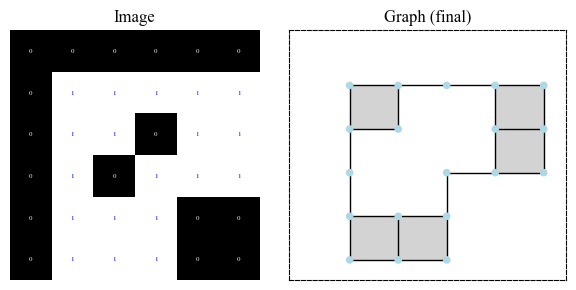

#ones in diag(M0_inv): 19
#ones in diag(M1): 24
#ones in diag(M2): 5

sorted diag(M0_inv): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

sorted diag(M1): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

sorted diag(M2): 
[1. 1. 1. 1. 1.]

generalized eigen decomposition: eig(L1, M1)
Ground truth #holes: Betti1=1
extimated betti number = 1.0
sorted normalised eigenvalues:
 [2.23096409e-16 3.19631064e-02 4.07291382e-02 1.65912172e-01
 1.81665227e-01 2.85487525e-01 2.94361238e-01 3.71648010e-01
 3.71648010e-01 4.35245267e-01 4.73568709e-01 5.57472015e-01
 5.57472015e-01 5.92547678e-01 6.35793868e-01 6.46238111e-01
 7.43296020e-01 7.49983248e-01 7.65617780e-01 8.96398681e-01
 9.29120025e-01 9.29120025e-01 9.80744473e-01 1.00000000e+00]

Ground truth #connected components: Betti0=1
extimated betti number = 1.0
sorted normalised eigenvalues:
 [6.80938287e-17 3.19631064e-02 4.07291382e-02 1.65912172e-01
 1.81665227e-01 2.85487525e-01 2.94361238e-01 3.

In [5]:
SD = 0.9
Epsilon = 1e-15
threshold = 1e-15

# test with sample binary data
# ---------------------------------------
# Define the sample_img array (1 hole)
sample_img = np.array([[0,0,0,0,0,0],
                       [0,1,1,1,1,1],
                       [0,1,1,0,1,1],
                       [0,1,0,1,1,1],
                       [0,1,1,1,0,0],
                       [0,1,1,1,0,0]])

# Display the sample_img and the graph
plot_image_graph(sample_img)

# construct d and M
d0 = cal_d0(sample_img.shape)
d1 = cal_d1(d0, sample_img.shape)
M0_inv = cal_M0_inv(sample_img)
M1 = cal_M1(d0, d1, sample_img, sd=SD)
M2 = cal_M2(d1, M1)

# remove vertices, edges, faces
d0, d1, M0_inv, M1, M2 = remove_v(d0, d1, M0_inv, M1, M2, threshold)
d0, d1, M1, M2 = remove_e(d0, d1, M1, M2, threshold)
d1, M2 = remove_f(d1, M2, threshold)

print(f"#ones in diag(M0_inv): {np.count_nonzero(np.abs(M0_inv-1.)<=Epsilon)}")
print(f"#ones in diag(M1): {np.count_nonzero(np.abs(M1-1.)<=Epsilon)}")
print(f"#ones in diag(M2): {np.count_nonzero(np.abs(M2-1.)<=Epsilon)}\n")
print(f"sorted diag(M0_inv): \n{np.sort(np.diag(M0_inv))}\n")
print(f"sorted diag(M1): \n{np.sort(np.diag(M1))}\n")
print(f"sorted diag(M2): \n{np.sort(np.diag(M2))}\n")

print(f"==============\ngeneralized eigen decomposition: eig(L1, M1)\n==============")
# generalized eigen decomposition
L1 = M1 @ d0 @ M0_inv @ d0.T @ M1 + d1.T @ M2 @ d1
eigenV, eigenVec = eigh(L1, M1)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #holes: Betti1=1")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")

L0 = M0_inv @ d0.T @ M1 @ d0
eigenV, eigenVec = eigh(L0)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #connected components: Betti0=1")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")


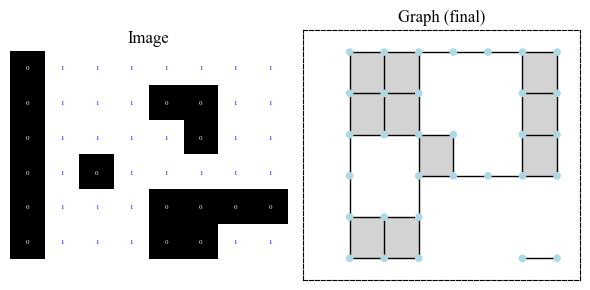

#ones in diag(M0_inv): 32
#ones in diag(M1): 42
#ones in diag(M2): 10

sorted diag(M0_inv): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]

sorted diag(M1): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

sorted diag(M2): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

generalized eigen decomposition: eig(L1, M1)
Ground truth #holes: Betti1=2
extimated betti number = 1.9999999999999991
sorted normalised eigenvalues:
 [3.23210406e-17 1.89324148e-16 1.41640290e-02 3.45727242e-02
 6.30867135e-02 9.45143091e-02 1.41321123e-01 1.55812921e-01
 2.13762776e-01 2.28157443e-01 2.84155634e-01 2.97049105e-01
 3.17016481e-01 3.17016481e-01 3.17016481e-01 3.45348947e-01
 3.82924284e-01 4.09868459e-01 4.15499161e-01 4.59563002e-01
 4.75524722e-01 4.75524722e-01 4.92195897e-01 5.19642043e-01
 5.36632659e-01 5.81545697e-01 5.92775714e-01 6.34032962e-01
 6.34032962e-01 6.34032962e-01

In [6]:
SD = 0.9
Epsilon = 1e-15
threshold = 1e-15

# test with sample binary data
# ---------------------------------------
# Define the sample_img array (2 holes)
sample_img = np.array([[0,1,1,1,1,1,1,1],
                       [0,1,1,1,0,0,1,1],
                       [0,1,1,1,1,0,1,1],
                       [0,1,0,1,1,1,1,1],
                       [0,1,1,1,0,0,0,0],
                       [0,1,1,1,0,0,1,1]])

# Display the sample_img and the graph
plot_image_graph(sample_img)

# construct d and M
d0 = cal_d0(sample_img.shape)
d1 = cal_d1(d0, sample_img.shape)
M0_inv = cal_M0_inv(sample_img)
M1 = cal_M1(d0, d1, sample_img, sd=SD)
M2 = cal_M2(d1, M1)

# remove vertices, edges, faces
d0, d1, M0_inv, M1, M2 = remove_v(d0, d1, M0_inv, M1, M2, threshold)
d0, d1, M1, M2 = remove_e(d0, d1, M1, M2, threshold)
d1, M2 = remove_f(d1, M2, threshold)

print(f"#ones in diag(M0_inv): {np.count_nonzero(np.abs(M0_inv-1.)<=Epsilon)}")
print(f"#ones in diag(M1): {np.count_nonzero(np.abs(M1-1.)<=Epsilon)}")
print(f"#ones in diag(M2): {np.count_nonzero(np.abs(M2-1.)<=Epsilon)}\n")
print(f"sorted diag(M0_inv): \n{np.sort(np.diag(M0_inv))}\n")
print(f"sorted diag(M1): \n{np.sort(np.diag(M1))}\n")
print(f"sorted diag(M2): \n{np.sort(np.diag(M2))}\n")

print(f"==============\ngeneralized eigen decomposition: eig(L1, M1)\n==============")
# generalized eigen decomposition
L1 = M1 @ d0 @ M0_inv @ d0.T @ M1 + d1.T @ M2 @ d1
eigenV, eigenVec = eigh(L1, M1)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #holes: Betti1=2")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")

L0 = M0_inv @ d0.T @ M1 @ d0
eigenV, eigenVec = eigh(L0)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #connected components: Betti0=2")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")


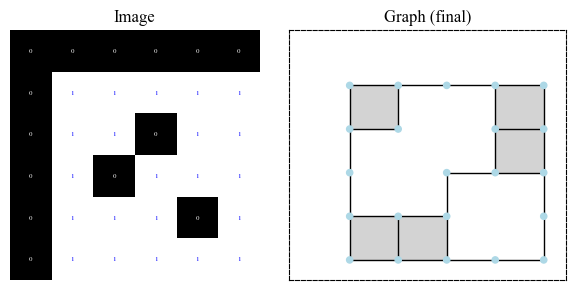

#ones in diag(M0_inv): 22
#ones in diag(M1): 28
#ones in diag(M2): 5

sorted diag(M0_inv): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

sorted diag(M1): 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]

sorted diag(M2): 
[1. 1. 1. 1. 1.]

generalized eigen decomposition: eig(L1, M1)
Ground truth #holes: Betti1=2
extimated betti number = 2.0
sorted normalised eigenvalues:
 [1.80449296e-16 2.12598605e-16 3.36096059e-02 4.05753030e-02
 9.61012376e-02 1.68890143e-01 1.77734729e-01 2.65138546e-01
 3.01471837e-01 3.62079091e-01 3.62079091e-01 4.05154129e-01
 4.76263923e-01 5.04007167e-01 5.43118636e-01 5.43118636e-01
 6.01381682e-01 6.03612188e-01 6.42459427e-01 6.96341950e-01
 7.24158181e-01 7.71863403e-01 7.72089520e-01 8.77651825e-01
 9.05197726e-01 9.05197726e-01 9.79709739e-01 1.00000000e+00]

Ground truth #connected components: Betti0=1
extimated betti number = 1.0
sorted normalised eigenvalues:
 [7.29966867e-17 3.36096059

In [7]:
SD = 0.9
Epsilon = 1e-15
threshold = 1e-15

# test with sample binary data
# ---------------------------------------
# Define the sample_img array (2 holes)
sample_img = np.array([[0,0,0,0,0,0],
                       [0,1,1,1,1,1],
                       [0,1,1,0,1,1],
                       [0,1,0,1,1,1],
                       [0,1,1,1,0,1],
                       [0,1,1,1,1,1]])

# Display the sample_img and the graph
plot_image_graph(sample_img)

# construct d and M
d0 = cal_d0(sample_img.shape)
d1 = cal_d1(d0, sample_img.shape)
M0_inv = cal_M0_inv(sample_img)
M1 = cal_M1(d0, d1, sample_img, sd=SD)
M2 = cal_M2(d1, M1)

# remove vertices, edges, faces
d0, d1, M0_inv, M1, M2 = remove_v(d0, d1, M0_inv, M1, M2, threshold)
d0, d1, M1, M2 = remove_e(d0, d1, M1, M2, threshold)
d1, M2 = remove_f(d1, M2, threshold)

print(f"#ones in diag(M0_inv): {np.count_nonzero(np.abs(M0_inv-1.)<=Epsilon)}")
print(f"#ones in diag(M1): {np.count_nonzero(np.abs(M1-1.)<=Epsilon)}")
print(f"#ones in diag(M2): {np.count_nonzero(np.abs(M2-1.)<=Epsilon)}\n")
print(f"sorted diag(M0_inv): \n{np.sort(np.diag(M0_inv))}\n")
print(f"sorted diag(M1): \n{np.sort(np.diag(M1))}\n")
print(f"sorted diag(M2): \n{np.sort(np.diag(M2))}\n")

print(f"==============\ngeneralized eigen decomposition: eig(L1, M1)\n==============")
# generalized eigen decomposition
L1 = M1 @ d0 @ M0_inv @ d0.T @ M1 + d1.T @ M2 @ d1
eigenV, eigenVec = eigh(L1, M1)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #holes: Betti1=2")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")

L0 = M0_inv @ d0.T @ M1 @ d0
eigenV, eigenVec = eigh(L0)
eigenV_norm = np.abs(eigenV / np.max(eigenV))
print(f"Ground truth #connected components: Betti0=1")
print(f"extimated betti number = {eigenValue2BettiNumber(eigenV_norm)}")
print(f"sorted normalised eigenvalues:\n {np.sort(eigenV_norm)}")
print(f"==============\n")




* We use generalized eigen decomposition
* We remove vertices, edges, faces with weights less than a threshold
* Data: 2 holes


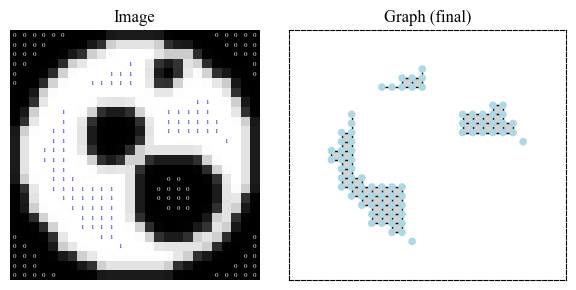

thresholds used to remove v, e, and f:
thresholds=[0.     0.002  0.004  0.006  0.008  0.01   0.012  0.014  0.016  0.018
 0.02   0.022  0.024  0.026  0.028  0.03   0.032  0.034  0.036  0.038
 0.04   0.042  0.044  0.046  0.048  0.05   0.052  0.054  0.056  0.058
 0.06   0.062  0.064  0.066  0.068  0.07   0.072  0.074  0.076  0.078
 0.08   0.082  0.084  0.086  0.088  0.09   0.092  0.094  0.096  0.098
 0.1    0.102  0.104  0.106  0.108  0.11   0.112  0.114  0.116  0.118
 0.12   0.122  0.124  0.126  0.128  0.13   0.132  0.134  0.136  0.138
 0.14   0.142  0.144  0.146  0.148  0.15   0.152  0.154  0.156  0.158
 0.16   0.162  0.164  0.166  0.168  0.17   0.172  0.174  0.176  0.178
 0.18   0.182  0.184  0.186  0.188  0.19   0.192  0.194  0.196  0.198
 0.2    0.202  0.204  0.206  0.208  0.21   0.212  0.214  0.216  0.218
 0.22   0.222  0.224  0.226  0.228  0.23   0.232  0.234  0.236  0.238
 0.24   0.242  0.244  0.246  0.248  0.25   0.252  0.254  0.256  0.258
 0.26   0.262  0.264  0.266  0.268  0.27

In [8]:
SD = 1
Epsilon = 1e-15
# Sigmas = np.arange(0.2,1.0,0.1) # used to generate a few smoothed images
Sigmas = np.arange(0.5, 1, 2)  # used to generate a few smoothed images
# Thresholds = np.concatenate((np.power(10.0, np.arange(-14, 0, 2)), np.arange(0.1, 1, 0.1), 1-(np.power(10.0, np.arange(-1, -8, -1))))) # used to remove v,e,f
Thresholds = np.concatenate((np.arange(0, 1, 1 / 500), np.arange(0.9999, 1, 1)))
num_eigenV_shown = 5

print("==========================\n"
      "* We use generalized eigen decomposition\n"
      "* We remove vertices, edges, faces with weights less than a threshold\n"
      "* Data: 2 holes\n"
      "==========================")

# test with data_prob and data_mask
# ---------------------------------------

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# parameters: Gaussian smoothing applied to the binary mask
smooth_Gaussian_SDs = np.arange(0.4, 1.6 + Epsilon, 0.2)
# image size and down-sampling factor
image_size = 64
scale = 2 / 5
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Initialize the binary image
data_mask = np.zeros((image_size, image_size), dtype=np.float32)

# Define the main circle
main_center = (32, 32)
main_radius = 30
rr, cc = disk(main_center, main_radius)
data_mask[rr, cc] = 1
# Define the first hole
hole1_center = (26, 26)
hole1_radius = 8
rr, cc = disk(hole1_center, hole1_radius)
data_mask[rr, cc] = 0
# Define the second hole
hole2_center = (42, 42)
hole2_radius = 12
rr, cc = disk(hole2_center, hole2_radius)
data_mask[rr, cc] = 0
# Define the third hole
hole3_center = (10, 40)
hole3_radius = 4
rr, cc = disk(hole3_center, hole3_radius)
data_mask[rr, cc] = 0

# Downsample the data_mask to size [16, 16] using nearest neighbor interpolation
data_mask = zoom(data_mask, zoom=(scale, scale), order=0)

# generate a few smoothed images
for sigma in Sigmas:
    # Smooth the binary mask
    data_prob = gaussian_filter(data_mask.astype(np.float32), sigma=sigma)
    # Normalize the smoothed image to have background intensity 0 and foreground intensity 1
    data_prob = (data_prob - data_prob.min()) / (data_prob.max() - data_prob.min())

    # Display the image and the graph
    plot_image_graph(data_prob)
    # -------------------------------------
    # test with data_prob
    # -------------------------------------

    Betti_0 = np.empty(len(Thresholds))
    sorted_abs_eigenVs_L0 = np.empty([num_eigenV_shown, len(Thresholds)])
    sorted_raw_eigenVs_L0 = np.empty([num_eigenV_shown, len(Thresholds)])

    Betti_1 = np.empty(len(Thresholds))
    sorted_abs_eigenVs_L1 = np.empty([num_eigenV_shown, len(Thresholds)])
    sorted_raw_eigenVs_L1 = np.empty([num_eigenV_shown, len(Thresholds)])
    for idx, threshold in enumerate(Thresholds):
        # construct d and M
        i_data_binary = data_prob > threshold
        d0 = cal_d0(i_data_binary.shape)
        d1 = cal_d1(d0, i_data_binary.shape)
        M0_inv = cal_M0_inv(i_data_binary)
        M1 = cal_M1(d0, d1, i_data_binary, sd=SD)
        M2 = cal_M2(d1, M1)

        # remove vertices, edges, faces
        i_d0, i_d1, i_M0_inv, i_M1, i_M2 = reset_v_v2(d0, d1, M0_inv, M1, M2, 0)
        i_d0, i_d1, i_M1, i_M2 = reset_e_v2(i_d0, i_d1, i_M1, i_M2, 0)
        i_d1, i_M2 = reset_f_v2(i_d1, i_M2, 0)

        # generalized eigen decomposition
        i_L1 = i_M1 @ i_d0 @ i_M0_inv @ i_d0.T @ i_M1 + i_d1.T @ i_M2 @ i_d1
        i_eigenV_L1, _ = eigh(i_L1, i_M1 + sys.float_info.epsilon * np.eye(i_M1.shape[0]))
        i_eigenV_norm_L1 = np.abs(i_eigenV_L1 / np.max(i_eigenV_L1))

        i_L0 = fractional_matrix_power(i_M0_inv, 0.5) @ i_d0.T @ i_M1 @ i_d0 @ fractional_matrix_power(i_M0_inv, 0.5)
        i_eigenV_L0, _ = eigh(i_L0)
        i_eigenV_norm_L0 = np.abs(i_eigenV_L0 / np.max(i_eigenV_L0))

        # log Betti_1
        trivial_eignV_L1 = count_zero_columns(i_M1)
        Betti_1[idx] = eigenValue2BettiNumber(i_eigenV_norm_L1) - trivial_eignV_L1
        if trivial_eignV_L1 + num_eigenV_shown <= i_eigenV_norm_L1.shape:
            sorted_abs_eigenVs_L1[:, idx] = np.sort(np.abs(i_eigenV_norm_L1))[
                                            trivial_eignV_L1:trivial_eignV_L1 + num_eigenV_shown]
        elif trivial_eignV_L1 < i_eigenV_norm_L1.shape:
            n_valid_eigenVs = i_eigenV_norm_L1.shape - trivial_eignV_L1
            sorted_abs_eigenVs_L1[:, idx] = np.concatenate((np.sort(np.abs(i_eigenV_norm_L1))[
                                            trivial_eignV_L1:], np.empty(num_eigenV_shown-n_valid_eigenVs)))
        else:
            sorted_abs_eigenVs_L1[:, idx] = np.empty([num_eigenV_shown])

        # log Betti_0
        trivial_eignV_L0 = count_zero_columns(i_M0_inv)
        Betti_0[idx] = eigenValue2BettiNumber(i_eigenV_norm_L0) - trivial_eignV_L0
        if trivial_eignV_L0 + num_eigenV_shown <= i_eigenV_norm_L0.shape:
            sorted_abs_eigenVs_L0[:, idx] = np.sort(np.abs(i_eigenV_norm_L0))[
                                            trivial_eignV_L0:trivial_eignV_L0 + num_eigenV_shown]
        elif trivial_eignV_L0 < i_eigenV_norm_L0.shape:
            n_valid_eigenVs = i_eigenV_norm_L0.shape - trivial_eignV_L0
            sorted_abs_eigenVs_L0[:, idx] = np.concatenate((np.sort(np.abs(i_eigenV_norm_L0))[
                                            trivial_eignV_L0:], np.empty(num_eigenV_shown-n_valid_eigenVs)))
        else:
            sorted_abs_eigenVs_L0[:, idx] = np.empty([num_eigenV_shown])

            
    print(f"thresholds used to remove v, e, and f:\nthresholds={Thresholds}\n")
    print(f"Betti1 changed across thresholds: \n{Betti_1}\n")
    print(f"Betti0 changed across thresholds: \n{Betti_0}\n")
    print(f"(L1) sorted first {num_eigenV_shown} abs eigenvalues (col are filtration dim):\n {sorted_abs_eigenVs_L1}\n")
    print(f"(L0) sorted first {num_eigenV_shown} abs eigenvalues (col are filtration dim):\n {sorted_abs_eigenVs_L0}\n")

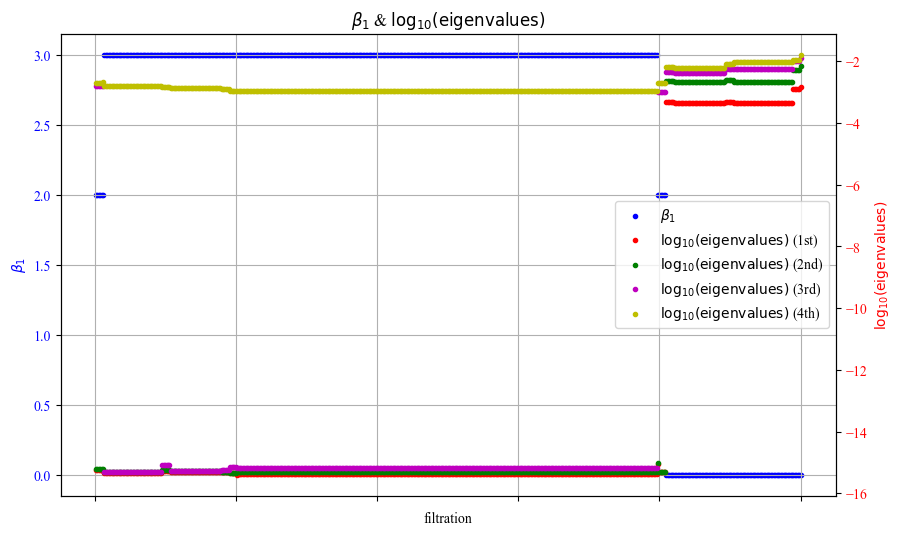

In [9]:
# plot figures using data from previous experiments
n = 501
x = np.linspace(0, 1, n).reshape(n, 1)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Betti_1 on the primary y-axis
ax1.scatter(x[1:], Betti_1[1:], color='b', marker='.', label=r'$\beta_1$ ')
ax1.set_xlabel('filtration')
ax1.set_ylabel(r'$\beta_1$', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.scatter(x[1:], np.log10(sorted_abs_eigenVs_L1[0, 1:]), color='r', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (1st)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L1[1, 1:]), color='g', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (2nd)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L1[2, 1:]), color='m', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (3rd)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L1[3, 1:]), color='y', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (4th)')
ax2.set_ylabel(r'$\text{log}_{10}(\text{eigenvalues})$', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both y-axes
ax1.set_xticklabels([]) 
ax2.set_xticklabels([]) 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)

# Add a grid
ax1.grid(True)

# Show the plot
plt.title(r'$\beta_1$ & $\text{log}_{10}(\text{eigenvalues})$')
plt.show()

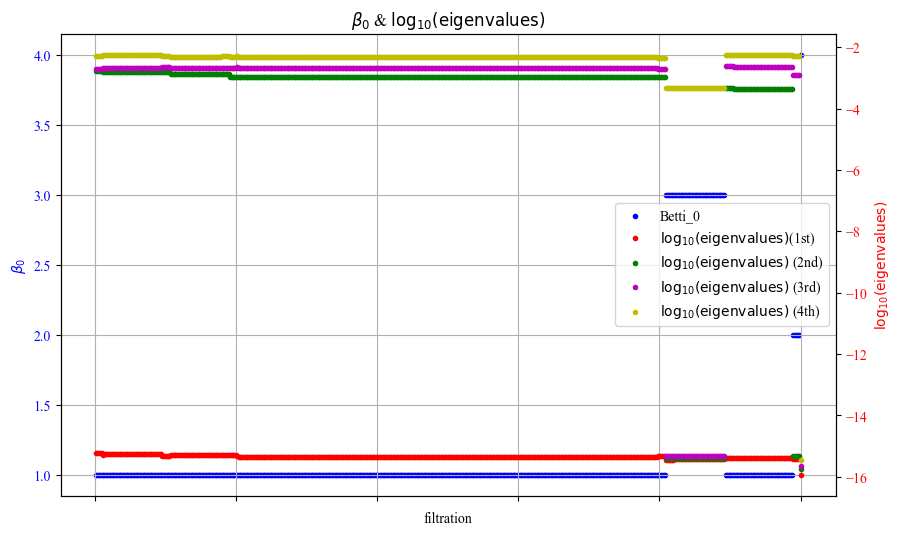

In [11]:
# plot figures using data from previous experiments
n = 501
x = np.linspace(0, 1, n).reshape(n, 1)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Betti_1 on the primary y-axis
ax1.scatter(x[1:], Betti_0[1:], color='b', marker='.', label='Betti_0')
ax1.set_xlabel('filtration')
ax1.set_ylabel(r'$\beta_0$', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.scatter(x[1:], np.log10(sorted_abs_eigenVs_L0[0, 1:]), color='r', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$(1st)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L0[1, 1:]), color='g', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (2nd)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L0[2, 1:]), color='m', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (3rd)')
ax2.scatter(x[1:],  np.log10(sorted_abs_eigenVs_L0[3, 1:]), color='y', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$ (4th)')
ax2.set_ylabel(r'$\text{log}_{10}(\text{eigenvalues})$', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both y-axes
ax1.set_xticklabels([]) 
ax2.set_xticklabels([]) 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)

# Add a grid
ax1.grid(True)

# Show the plot
plt.title(r'$\beta_0$ & $\text{log}_{10}(\text{eigenvalues})$')
plt.show()

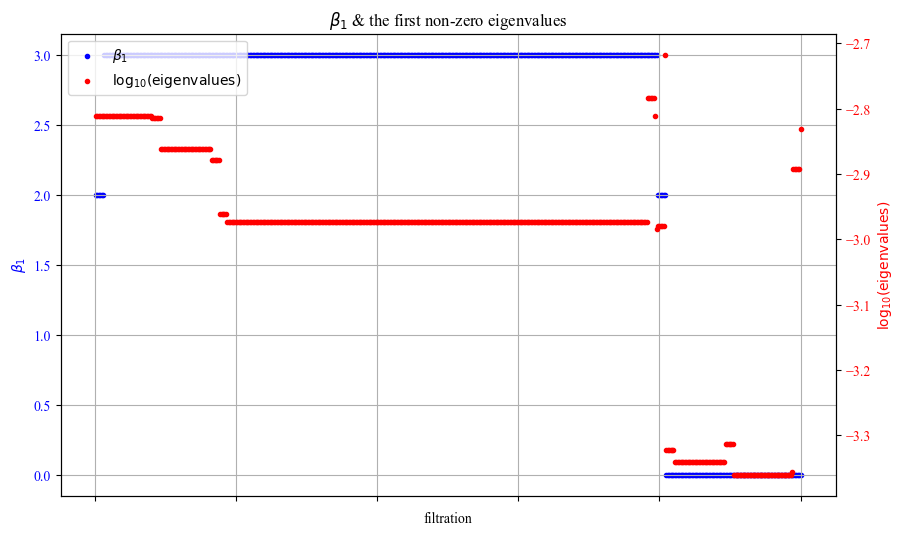

In [12]:
# plot figures using data from previous experiments
n = 501
x = np.linspace(0, 10, n).reshape(n, 1)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

Betti_1_r = np.round(Betti_1, decimals=0)
# Plot Betti_1 on the primary y-axis
ax1.scatter(x[1:], Betti_1_r[1:], color='b', marker='.', label=r'$\beta_1$')
ax1.set_xlabel('filtration')
ax1.set_ylabel(r'$\beta_1$', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
first_nonzero_eigenV = np.concatenate((sorted_abs_eigenVs_L1[3, Betti_1_r==3],sorted_abs_eigenVs_L1[2, Betti_1_r==2],sorted_abs_eigenVs_L1[1, Betti_1_r==1],sorted_abs_eigenVs_L1[0, Betti_1_r==0]), axis=0)

ax2 = ax1.twinx()
ax2.scatter(x[1:], np.log10(first_nonzero_eigenV[1:].flatten()), color='r', marker='.', label=r'$\text{log}_{10}(\text{eigenvalues})$')
ax2.set_ylabel(r'$\text{log}_{10}(\text{eigenvalues})$', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both y-axes
ax1.set_xticklabels([]) 
ax2.set_xticklabels([]) 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)

# Add a grid
ax1.grid(True)

# Show the plot
plt.title(r'$\beta_1$ & the first non-zero eigenvalues')
plt.show()